In [1]:
# Perform the standard numpy and units imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
# Set plot default figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity
import xarray as xr
import morticia.sensor.electro as electro
import morticia.sensor.optics as optics
from morticia.tools.xd import *
# This notebook is also used for development/testing of the electro module, so auto reload the electro module if it changes
%load_ext autoreload
%aimport morticia.sensor.electro
%aimport morticia.sensor.optics
%aimport morticia.tools.xd
%autoreload 1

In [6]:
# Build the Lens
# Set up the spectral transmission function for a optics.Lens object
spec_trans = xr.DataArray([ 0.0, 0.4, 0.75, 0.93, 0.925, 0.91, 0.89, 0.4, 0.0],                      
                   [('wvl', [550., 600, 650, 700, 750, 800, 850, 950, 1000], {'units': 'nm'})], 
                   name='trn',
                   attrs={'units': '', 'extrap_val': 0.0})
spec_wfe = xr.DataArray([0.02, 0.01], [('wvl', [550.0, 1000.0], {'units': 'nm'})], 
                          name='wfe', 
                          attrs={'units': '', 'extrap_val': 0.0})
# Create a lens with above transmission and WFE
# Must provide focal length (efl), focal ratio (fno), transmission (trn), wavefront error (wfe) and central
# obscuration (obs)
mylens = optics.Lens(efl=[500, 'mm'], fno=8.0, trn=spec_trans, wfe=spec_wfe, obs=0.5)

In [7]:
# Create a CCD Focal Plane Array model for the Kodak KAI11002 sensor
# First read the spectral quantum efficiency data
KodakKA11002_SQE = np.genfromtxt('./data/fpa/KodakKAI11002_SQE.csv', delimiter=',', skip_header=1)
# Convert to a DataArray
KodakKA11002_SQE = xr.DataArray(KodakKA11002_SQE[:,1], [('wvl', KodakKA11002_SQE[:,0], {'units': 'um'})], 
                                  name='sqe', attrs={'units':''})
# Instantiate the FocalPlaneArray object
KodakKA11002Mono = electro.FocalPlaneArray(pitch=[9.0, 9.0, 'um'], aperture=[9.0, 'um'], 
                                           pixels=[4008, 2672], wellcapacity=[60000.0, 'e'], 
                                           readnoise=[32.0, 'e'], darkcurrent=[3846.0, 'e/s'], 
                                           dsnu=[3.0, '%'], prnu=[2.0, '%'],
                                           sqe=KodakKA11002_SQE, darkcurrent_delta_t=[7.0, 'delta_degC'], 
                                           t_ref=[40.0, 'degC'],
                                           temperature=[25.0, 'degC'])

In [8]:
# Create a Camera based on above CCD (Remember a Camera here does not include a lens i.e. Camera body only)
Atik11000Mono = electro.Camera(fpa=KodakKA11002Mono, ad_bit_depth=[16, 'bit'])

D:\Projects\GitHub\MORTICIA\morticia\sensor\electro.py:309: UserWarning: Estimating Camera digital gain from bit depth and FPA well capacity
  warnings.warn('Estimating Camera digital gain from bit depth and FPA well capacity')


In [9]:
# Create and Imager based on Lens and Camera defined above
AtikMonoImager = electro.Imager(lens=mylens, camera=Atik11000Mono)

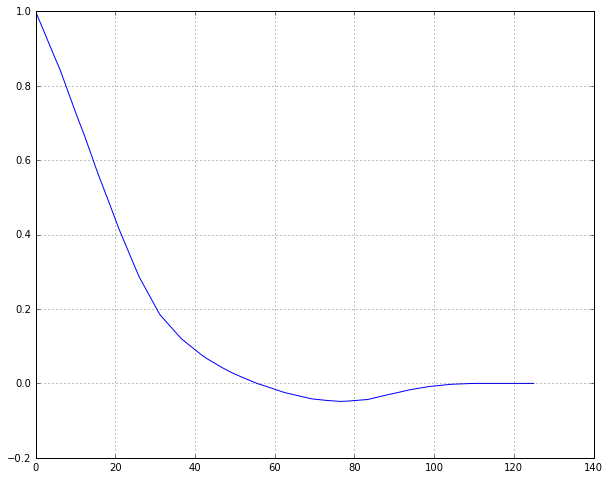

In [10]:
# Plot the through-frequency MTF at first wavelength, first focus position and first image orientation
plt.plot(AtikMonoImager.mtf['spfa'], AtikMonoImager.mtf[:,0,0,0])
plt.grid()

In [11]:
AtikMonoImager.mtf['wvl']

<xarray.DataArray 'wvl' (wvl: 18)>
array([  550.        ,   564.95468278,   580.74534161,   597.44408946,
         615.13157895,   633.89830508,   653.84615385,   675.09025271,
         697.76119403,   722.00772201,   748.        ,   775.93360996,
         806.03448276,   838.56502242,   873.8317757 ,   912.19512195,
         954.08163265,  1000.        ])
Coordinates:
  * wvl      (wvl) float64 550.0 565.0 580.7 597.4 615.1 633.9 653.8 675.1 ...
Attributes:
    long_name: Wavelength
    units: nm

In [12]:
# How about the color Atik camera combined with the same lens
# Build an SQE DataArray for the colour version of the KAI11002
# Read SQE data for the red, green and blue channels of the sensor
Red = np.genfromtxt('./data/fpa/KodakKAI11002_SQE_Red.csv', delimiter=',')
xdRed = xr.DataArray(Red[:,1], [('wvl', Red[:,0], {'units': 'nm'})], name='sqe', attrs={'units': ''})
Grn = np.genfromtxt('./data/fpa/KodakKAI11002_SQE_Green.csv', delimiter=',')
xdGrn = xr.DataArray(Grn[:,1], [('wvl', Grn[:,0], {'units': 'nm'})], name='sqe', attrs={'units': ''})
Blu = np.genfromtxt('./data/fpa/KodakKAI11002_SQE_Blue.csv', delimiter=',')
xdBlu = xr.DataArray(Blu[:,1], [('wvl', Blu[:,0], {'units': 'nm'})], name='sqe', attrs={'units': ''})
# Compile the three colour SQE response curves into a channels xr.DataArray
xdRed, xdGrn, xdBlu = xd_harmonise_interp((xdRed, xdGrn, xdBlu))  # First harmonise the wavelength axes
KodakKA11002ColorSQE = xr.DataArray([xdBlu, xdGrn, xdRed],[('chn', [0, 1, 2], {'labels': ['Blue', 'Green', 'Red']}), 
                                        ('wvl', xdRed['wvl'], {'units': 'nm'})],
                                        name='sqe', attrs={'units': ''})
# Can save this for later either by pickling or (for greater file longevity) writing to netCDF file


In [13]:
# Now create a camera based on the KodakKAI11002 color chip
# Use the Atik 11000 Colour camera as an example - it has 16-bit digitisation
KodakKA11002Color = electro.FocalPlaneArray(pitch=[9.0, 9.0, 'um'], aperture=[9.0, 'um'], 
                              pixels=[4008, 2672], wellcapacity=[60000.0, 'e'], 
                              readnoise=[32.0, 'e'], darkcurrent=[3846.0, 'e/s'], dsnu=[3.0, '%'], prnu=[2.0, '%'],
                              sqe=KodakKA11002ColorSQE, darkcurrent_delta_t=[7.0, 'delta_degC'], t_ref=[40.0, 'degC'],
                              temperature=[-30.0, 'degC'])  # Set operating temperature to -30 deg C
Atik11000Color = electro.Camera(fpa=KodakKA11002Color, ad_bit_depth=[16, 'bit'])


In [14]:
AtikColorImager = electro.Imager(lens=mylens, camera=Atik11000Color)

In [15]:
AtikColorImager.camera.fpa.sqe['chn']

<xarray.DataArray 'chn' (chn: 3)>
array([0, 1, 2])
Coordinates:
  * chn      (chn) int32 0 1 2
Attributes:
    labels: ['Blue', 'Green', 'Red']